### Shortlisted Models to try:
- FFT (baseline, done)
- N-Beats (done)
- Transformer
- Temporal Fusion Transformer 

In [1]:
import pandas as pd
from darts import TimeSeries
from darts.metrics.metrics import mape

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

#Loading the data

df_2016 = pd.read_csv("data/sg_west_2016.csv")
df_2017 = pd.read_csv("data/sg_west_2017.csv")
df_2018 = pd.read_csv("data/sg_west_2018.csv")
df_2019 = pd.read_csv("data/sg_west_2019.csv")
df_2020 = pd.read_csv("data/sg_west_2020.csv")

In [2]:
def create_dt_col(df: pd.DataFrame) -> pd.DataFrame:
    """Creates a datetime column from existing year, month, day and hour columns"""
    param_dict = dict(year=df["Year"], month=df["Month"], day=df["Day"], hour=df["Hour"])
    df["Datetime"] = pd.to_datetime(param_dict)
    return df

In [3]:
# Getting the date columns 
df_2016_interim = create_dt_col(df_2016)
df_2017_interim = create_dt_col(df_2017)
df_2018_interim = create_dt_col(df_2018)
df_2019_interim = create_dt_col(df_2019)
df_2020_interim = create_dt_col(df_2020)

In [4]:
df_2018_interim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Year                8760 non-null   int64         
 1   Month               8760 non-null   int64         
 2   Day                 8760 non-null   int64         
 3   Hour                8760 non-null   int64         
 4   Minute              8760 non-null   int64         
 5   Clearsky DHI        8760 non-null   int64         
 6   Clearsky DNI        8760 non-null   int64         
 7   Clearsky GHI        8760 non-null   int64         
 8   Cloud Type          8760 non-null   int64         
 9   Fill Flag           8760 non-null   int64         
 10  Ozone               8760 non-null   float64       
 11  Solar Zenith Angle  8760 non-null   float64       
 12  Precipitable Water  8760 non-null   float64       
 13  Temperature         8760 non-null   float64     

In [5]:
df_2018_interim.head(24)

,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Fill Flag,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,Dew Point,DHI,DNI,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed,Datetime
0,2018,1,1,0,0,0,0,0,7,0,0.250,152.74,5.9,25.9,25.5,0,0,0,97.47,0.14,1009,339,2.8,2018-01-01 00:00:00
1,2018,1,1,1,0,0,0,0,6,0,0.251,158.19,5.9,25.8,25.3,0,0,0,97.36,0.14,1008,341,3.0,2018-01-01 01:00:00
2,2018,1,1,2,0,0,0,0,7,0,0.251,154.87,5.9,25.7,25.2,0,0,0,97.03,0.14,1008,345,3.2,2018-01-01 02:00:00
3,2018,1,1,3,0,0,0,0,7,0,0.250,145.21,5.9,25.6,25.1,0,0,0,96.91,0.14,1007,347,3.3,2018-01-01 03:00:00
4,2018,1,1,4,0,0,0,0,6,0,0.250,132.99,5.8,25.5,24.9,0,0,0,96.74,0.14,1007,348,3.0,2018-01-01 04:00:00
5,2018,1,1,5,0,0,0,0,7,0,0.250,119.78,5.7,25.3,24.8,0,0,0,96.93,0.14,1007,345,2.6,2018-01-01 05:00:00
6,2018,1,1,6,0,0,0,0,7,0,0.250,106.15,5.6,25.2,24.6,0,0,0,96.51,0.14,1008,337,2.4,2018-01-01 06:00:00
7,2018,1,1,7,0,0,0,0,7,0,0.251,92.37,5.6,25.4,24.6,0,0,0,95.30,0.14,1009,327,2.4,2018-01-01 07:00:00
8,2018,1,1,8,0,66,370,139,9,3,0.235,78.56,6.3,25.4,24.8,7,0,7,96.38,0.14,1005,359,2.2,2018-01-01 08:00:00
9,2018,1,1,9,0,110,609,368,9,0,0.235,65.00,6.4,25.8,25.0,17,0,17,95.09,0.14,1006,1,1.8,2018-01-01 09:00:00


In [6]:
# Combining the 2018 and 2019 data together to form training data
full_df = pd.concat([df_2016_interim, df_2017_interim, df_2018_interim, df_2019_interim, df_2020_interim], ignore_index=True)

In [7]:
# Change the index to datetime for processing 
full_df.index = full_df["Datetime"]

In [8]:
weekly_df = full_df.groupby(pd.Grouper(freq="W")).mean()
weekly_df.head(10)

/tmp/ipykernel_1795/991135514.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  weekly_df = full_df.groupby(pd.Grouper(freq="W")).mean()


,Year,Month,Day,Hour,Minute,Clearsky DHI,Clearsky DNI,Clearsky GHI,Cloud Type,Fill Flag,Ozone,Solar Zenith Angle,Precipitable Water,Temperature,Dew Point,DHI,DNI,GHI,Relative Humidity,Surface Albedo,Pressure,Wind Direction,Wind Speed
Datetime,,,,,,,,,,,,,,,,,,,,,,,
2016-01-03,2016.0,1.0,2.0,11.5,0.0,66.638889,309.472222,276.750000,6.319444,0.402778,0.250236,90.755000,6.009722,26.850000,25.336111,64.194444,9.430556,69.138889,91.661389,0.142222,1011.972222,64.513889,2.747222
2016-01-10,2016.0,1.0,7.0,11.5,0.0,53.345238,344.934524,284.857143,3.791667,0.363095,0.251744,90.736667,5.411310,27.428571,25.324405,121.726190,148.357143,212.642857,88.786250,0.140000,1011.303571,32.976190,2.641667
2016-01-17,2016.0,1.0,14.0,11.5,0.0,59.767857,329.958333,284.202381,6.190476,0.315476,0.250768,90.716012,5.870833,27.742857,25.523214,115.607143,104.702381,177.761905,88.211667,0.141429,1008.964286,43.172619,2.017262
2016-01-24,2016.0,1.0,21.0,11.5,0.0,58.869048,336.910714,288.636905,6.000000,0.369048,0.248452,90.687857,5.727381,27.419643,25.386905,112.178571,97.857143,172.827381,89.056607,0.156190,1010.392857,49.297619,2.273810
2016-01-31,2016.0,1.0,28.0,11.5,0.0,65.642857,321.690476,289.988095,5.767857,0.422619,0.247744,90.652262,5.426190,27.402976,25.464286,126.404762,112.416667,196.666667,89.625060,0.154762,1010.309524,41.970238,2.777381
2016-02-07,2016.0,2.0,4.0,11.5,0.0,66.446429,324.630952,294.130952,6.547619,0.380952,0.245208,90.608095,5.520238,27.232143,25.427976,127.202381,112.940476,202.523810,90.354107,0.158095,1009.005952,24.363095,3.115476
2016-02-14,2016.0,2.0,11.0,11.5,0.0,68.047619,320.761905,295.589286,6.458333,0.244048,0.243577,90.554940,6.059524,26.792262,25.148214,126.422619,74.589286,177.166667,91.031726,0.151905,1009.904762,35.684524,2.572024
2016-02-21,2016.0,2.0,18.0,11.5,0.0,61.589286,337.214286,302.380952,4.761905,0.476190,0.246512,90.491845,5.382143,26.945833,24.741667,119.821429,121.351190,197.702381,88.236488,0.150000,1011.464286,31.428571,3.105357
2016-02-28,2016.0,2.0,25.0,11.5,0.0,63.565476,333.172619,303.946429,3.726190,0.511905,0.251060,90.416548,5.441071,26.882738,24.701786,123.708333,134.553571,210.523810,88.414107,0.150000,1012.017857,22.690476,3.339881


<Axes: xlabel='Datetime'>

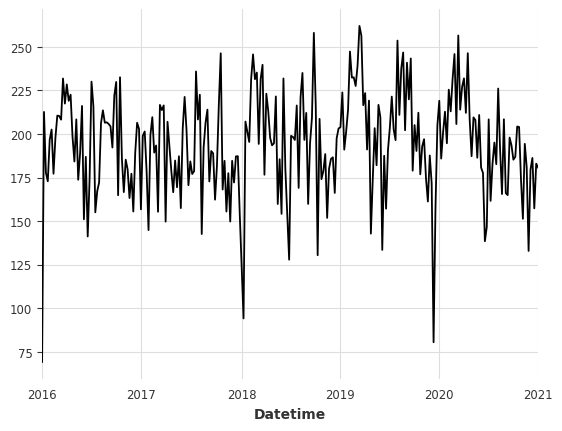

In [9]:
weekly_df["GHI"].plot()

In [10]:
# there are outlier low GHI as it is incomplete weeks
# preprocess the outlier low GHI to mean

weekly_df.loc[weekly_df["GHI"]<125, "GHI"] = weekly_df["GHI"].mean()

<Axes: xlabel='Datetime'>

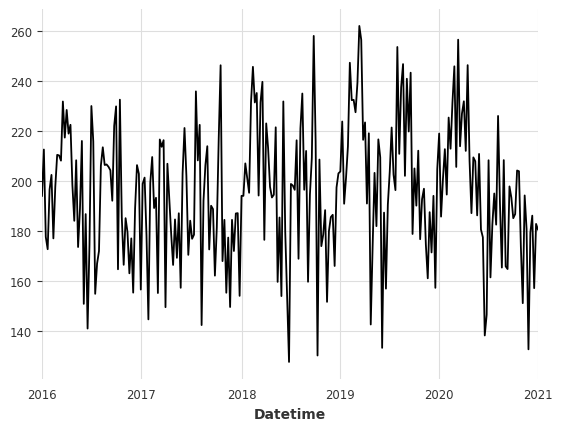

In [11]:
weekly_df["GHI"].plot()

In [12]:
series = TimeSeries.from_dataframe(weekly_df, value_cols="GHI", fill_missing_dates=True, freq="W")

In [13]:
train, val = series[:-52], series[-52:]
print(len(train))
print(len(val))

210
52


In [14]:
from darts.models import FFT

model = FFT()
model.fit(train)
prediction = model.predict(len(val))

/home/yutian/.cache/pypoetry/virtualenvs/pv-prediction-P2-Gyx4E-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
print(f"MAPE of FFT Prediction: {mape(val, prediction)}")

MAPE of FFT Prediction: 8.806117223976543


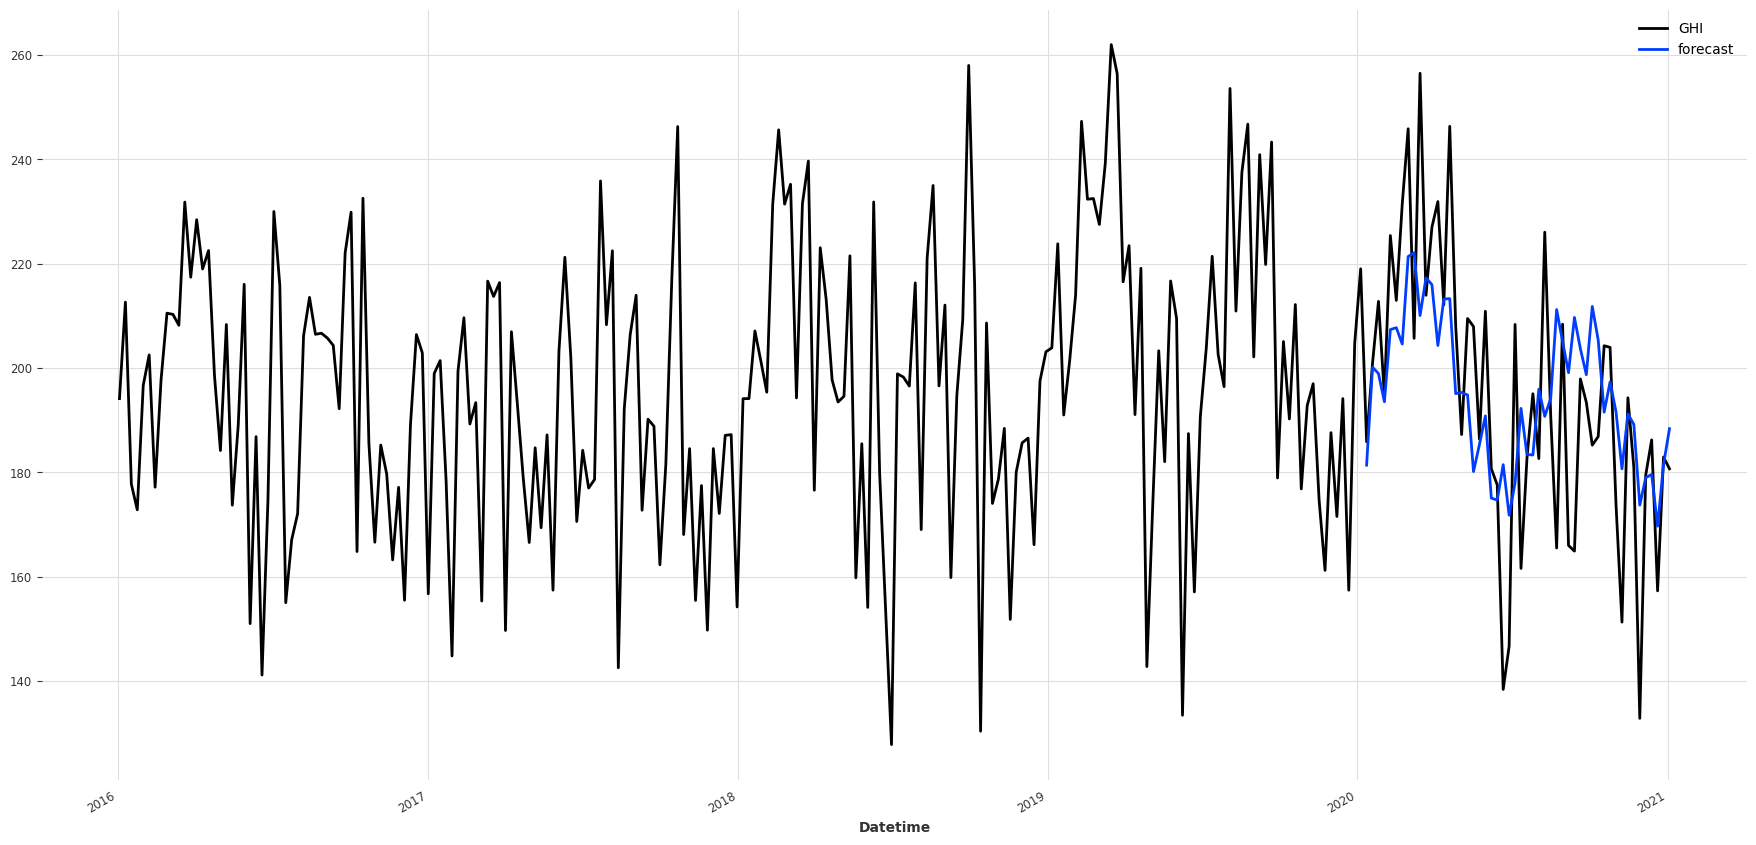

In [16]:
plt.figure(figsize=(22,10))
series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

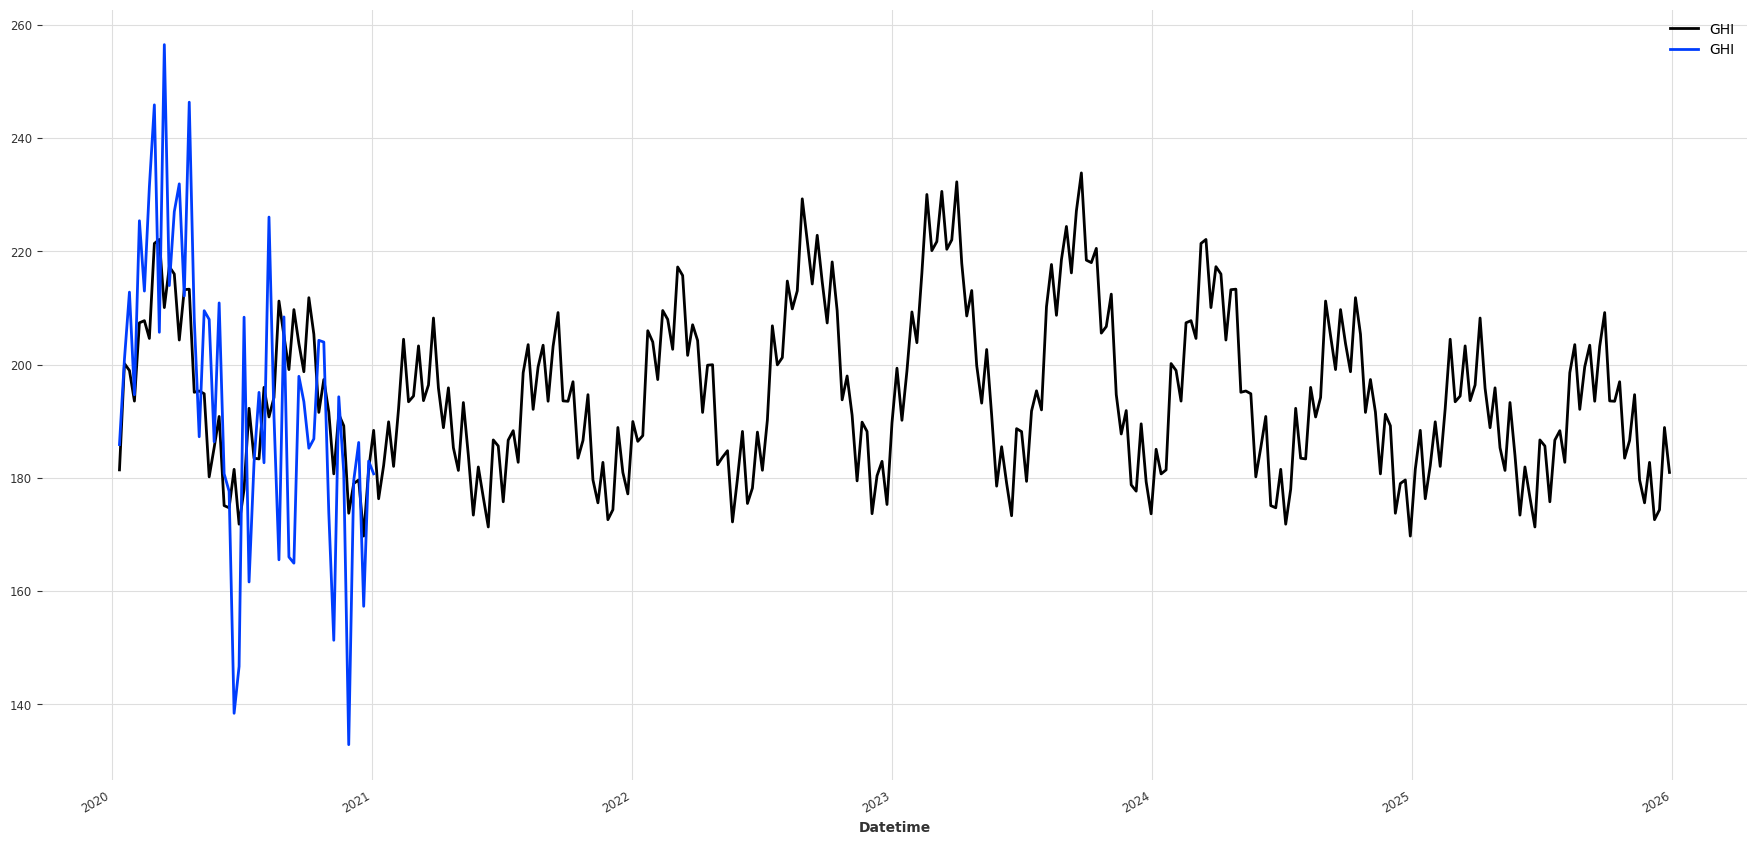

In [25]:
plt.figure(figsize=(22,10))
model.predict(52*6).plot()
val.plot()

In [26]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val))
print(f"MAPE of Exponential Smoothing Prediction: {mape(val, prediction)}")

MAPE of Exponential Smoothing Prediction: 12.587537049525874


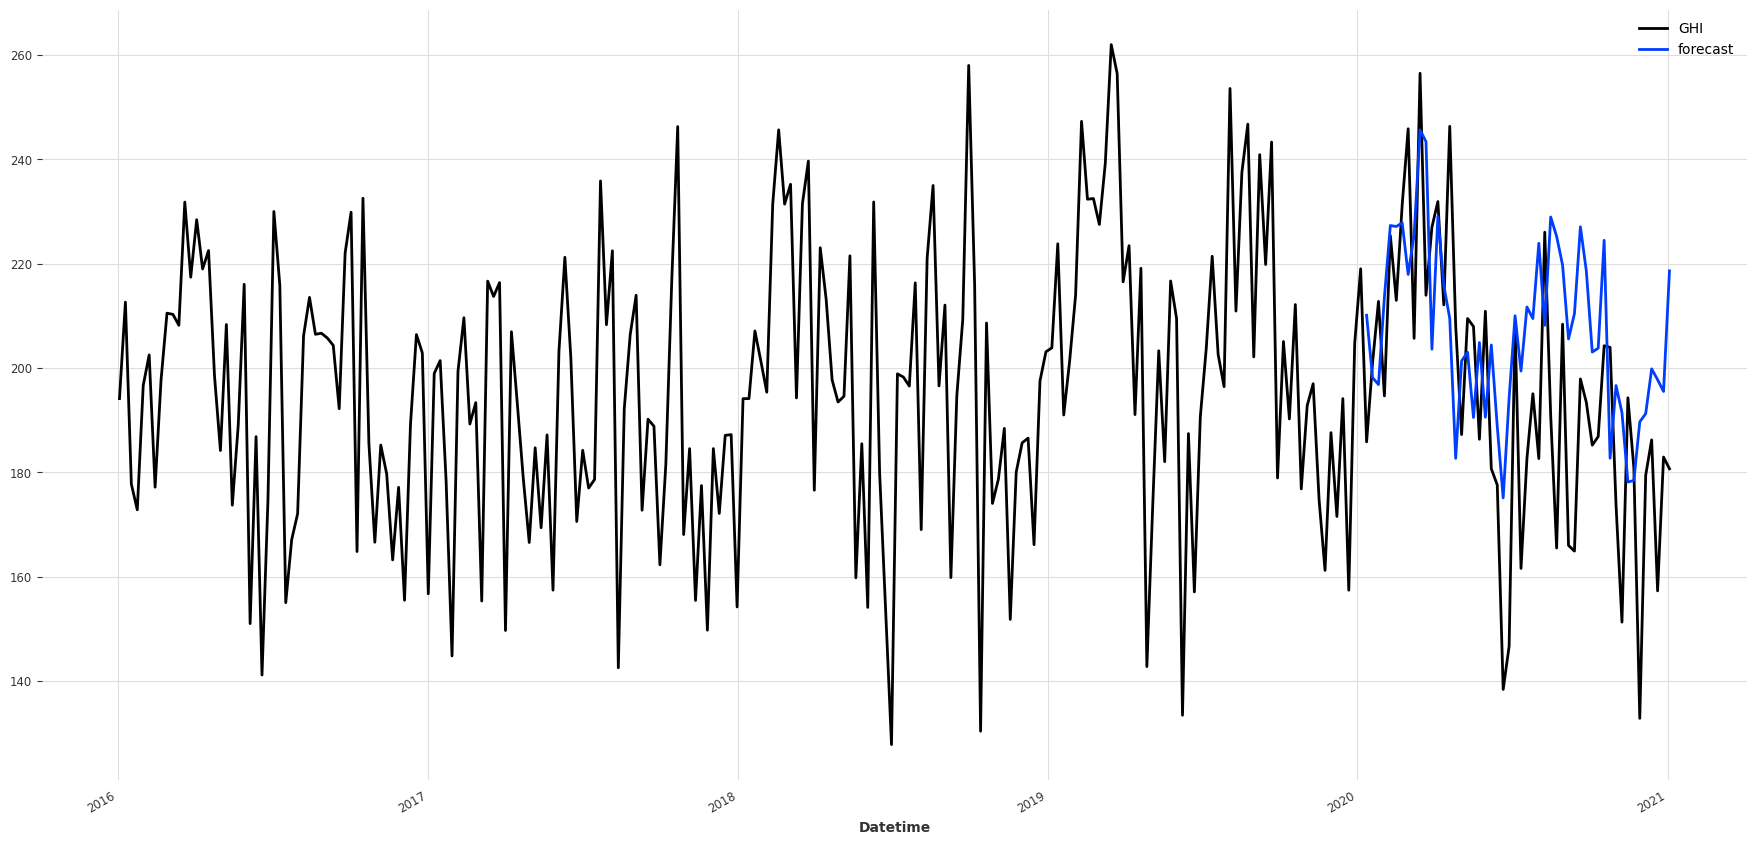

In [27]:
plt.figure(figsize=(22,10))
series.plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()

Choose FFT as the baseline univariate model. 
Next, build a multivariate model using mean temperature as a covariate. 

In [19]:
target_series = TimeSeries.from_dataframe(weekly_df, value_cols=["GHI"], fill_missing_dates=True, freq="W")
cov_series = TimeSeries.from_dataframe(weekly_df, value_cols=["Temperature"], fill_missing_dates=True, freq="W")

In [20]:
from darts.models import NBEATSModel
model = NBEATSModel(input_chunk_length=24, output_chunk_length=12, random_state=42)

train_cov, val_cov = cov_series[:-52], series[-52:]
train_target, val_target = target_series[:-52], target_series[-52:]

In [21]:
model.fit(train_target, past_covariates=train_cov, epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.4 M 
---------------------------------------------------
6.4 M     Trainable params
1.6 K     Non-trainable params
6.4 M     Total params
25.551    Total estimated model params size (MB)


Epoch 99: 100%|██████████| 6/6 [00:00<00:00,  9.41it/s, train_loss=20.50] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 6/6 [00:00<00:00,  9.35it/s, train_loss=20.50]


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=24, output_chunk_length=12, random_state=42)

In [22]:
pred_target = model.predict(series= train_target, past_covariates=cov_series, n=52)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]


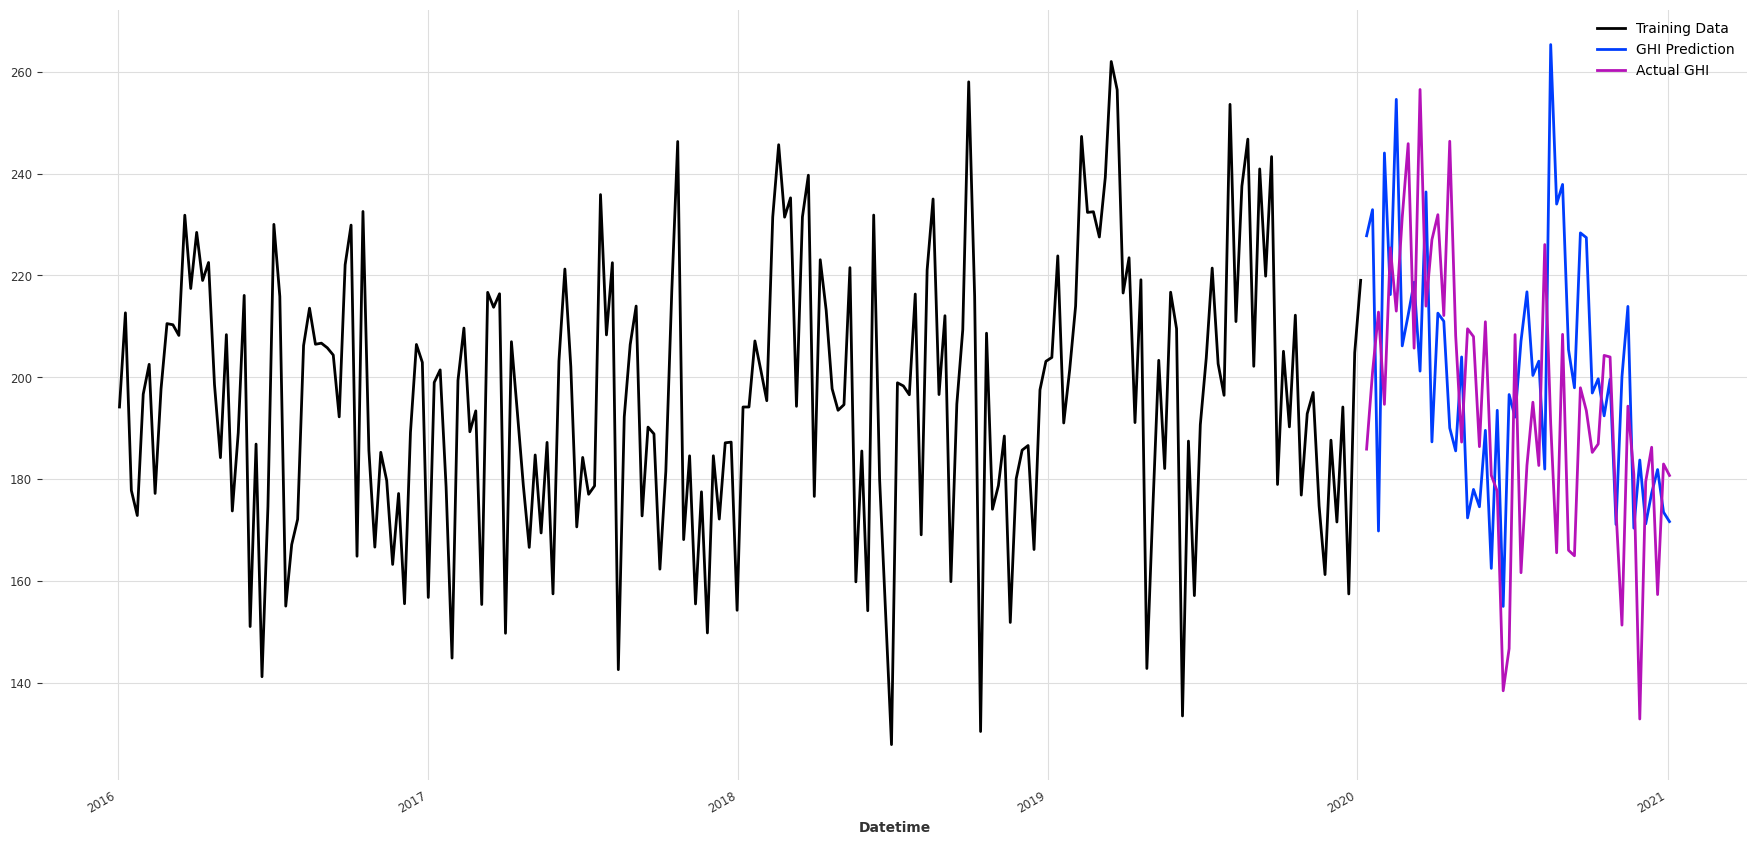

In [23]:
plt.figure(figsize=(22,10))
train_target.plot(label="Training Data")
pred_target.plot(label="GHI Prediction")
val_target.plot(label="Actual GHI")

In [24]:
mape(val_target, pred_target)

14.556400435677515